# Cassava Data Exploration

In this notebook I will take a look at some of the Cassava dataset images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
#style stuff
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.grid']=False
rcParams['xtick.minor.visible']=True
rcParams['ytick.minor.visible']=True
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

def set_plot(size):
    plt.rc('axes', titlesize=size)  # fontsize of the axes title
    plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size*0.8)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size*0.8)    # fontsize of the tick labels

In [3]:
print("tensorflow version:", tf.__version__)
print("pillow version:", PIL.__version__)

tensorflow version: 2.0.0
pillow version: 8.0.0


In [4]:
#create data directory path and count images
data_dir = pathlib.Path('../data/external/')

print("There are", len(list(data_dir.glob('train_images/*.jpg'))), "training images and", 
      len(list(data_dir.glob('test_images/*.jpg'))), "test images.")

There are 21397 training images and 1 test images.


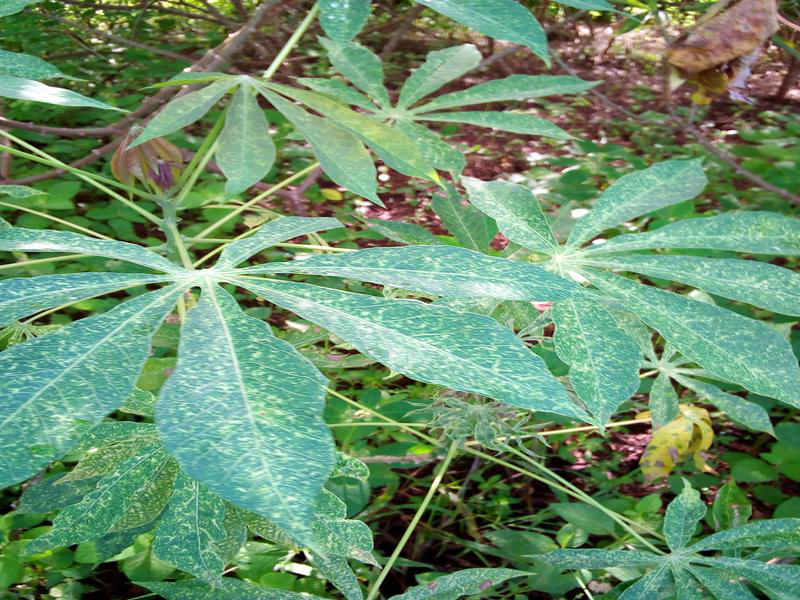

In [5]:
#Look at a few training images - load a list of image paths 
train_images = list(data_dir.glob('train_images/*.jpg'))

#display first training image
PIL.Image.open(str(train_images[0]))

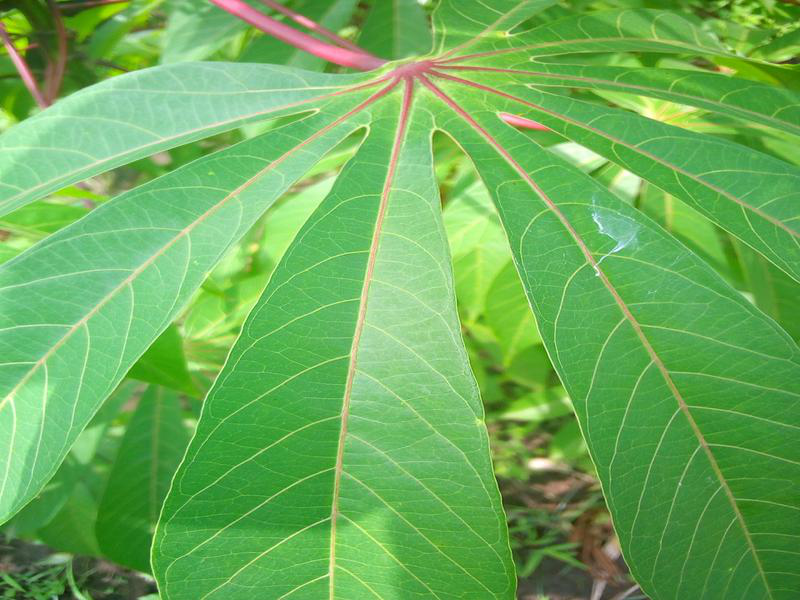

In [6]:
PIL.Image.open(str(train_images[5]))

In [7]:
#let's take a look at image sizes
sizes = []

for i in range(len(train_images)):
    size = PIL.Image.open(str(train_images[i])).size
    sizes.append(size) 
    
print("Set of possible image sizes:", set(sizes))

Set of possible image sizes: {(800, 600)}


In [8]:
train_df = pd.read_csv('../data/external/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [9]:
label_key = pd.read_json('../data/external/label_num_to_disease_map.json', typ='series')
label_key

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

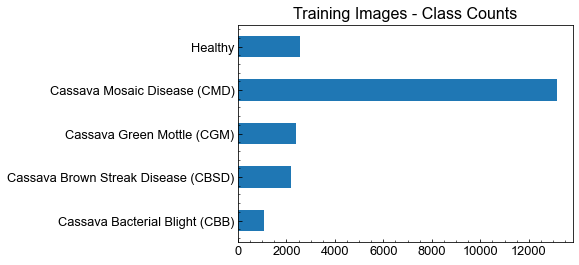

In [10]:
set_plot(16)
train_df.groupby('label').count().set_index(label_key).plot.barh(title='Training Images - Class Counts', legend=False)
plt.show()

In [11]:
def plot_image_with_label(index):
    img_id = str(train_images[index]).split('/')[-1]
    img_label = np.squeeze(train_df.loc[train_df['image_id'] == img_id, 'label'])
    label_name = label_key.loc[img_label]
    
    plt.imshow(PIL.Image.open(str(train_images[index])))
    plt.title(np.squeeze(label_name))
    plt.show()

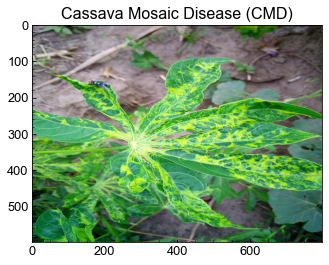

In [12]:
plot_image_with_label(10)

In [13]:
train_path = '../data/external/train_images'

In [14]:
def plot_six_by_class(cl):
    
    #get six random indices belonging to the selected class
    indx = train_df[train_df['label'] == cl].sample(6, axis=0).image_id.values
    
    #plot
    fig, axes = plt.subplots(2,3, figsize=(12,6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(PIL.Image.open(train_path + '/' + indx[i]))
    fig.suptitle(label_key[cl], fontsize=18)
    plt.tight_layout()
    plt.show()

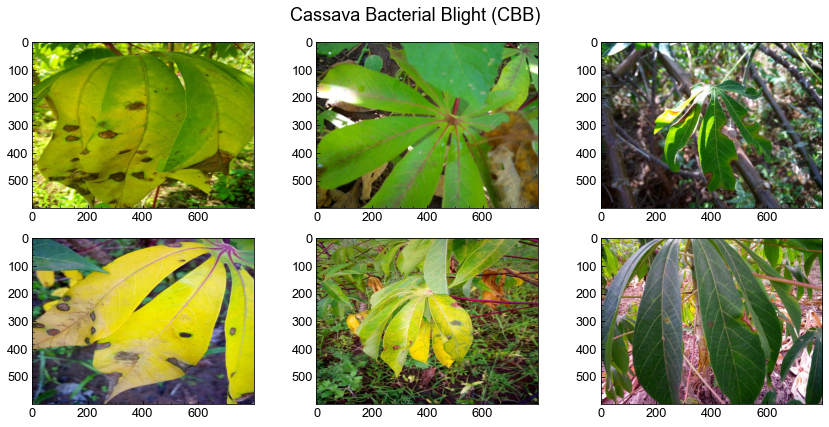

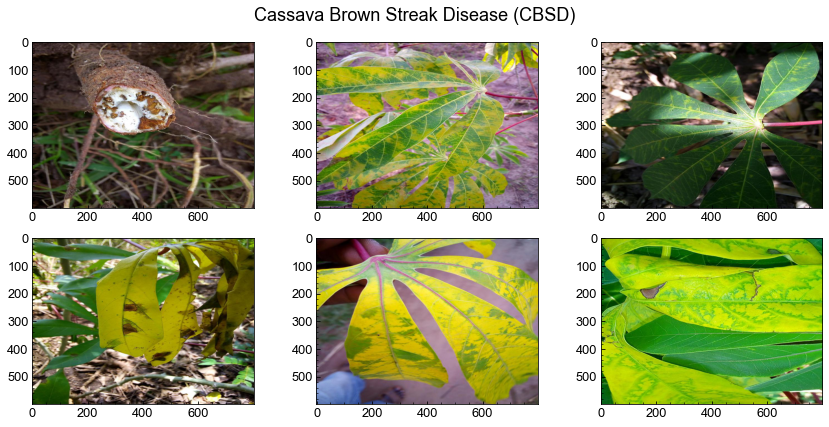

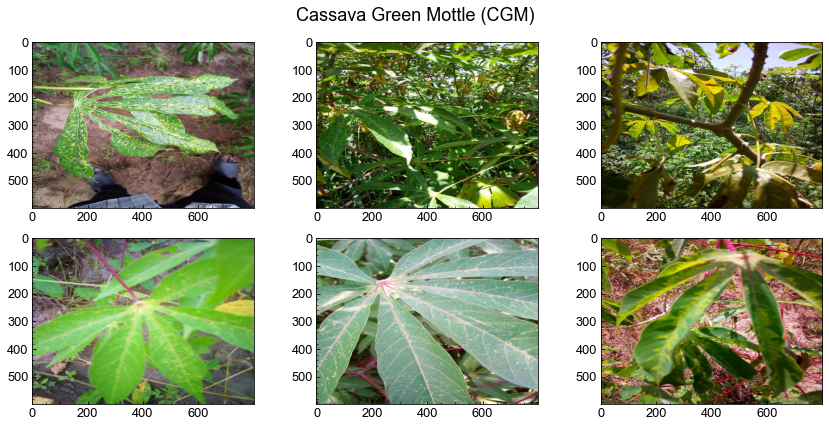

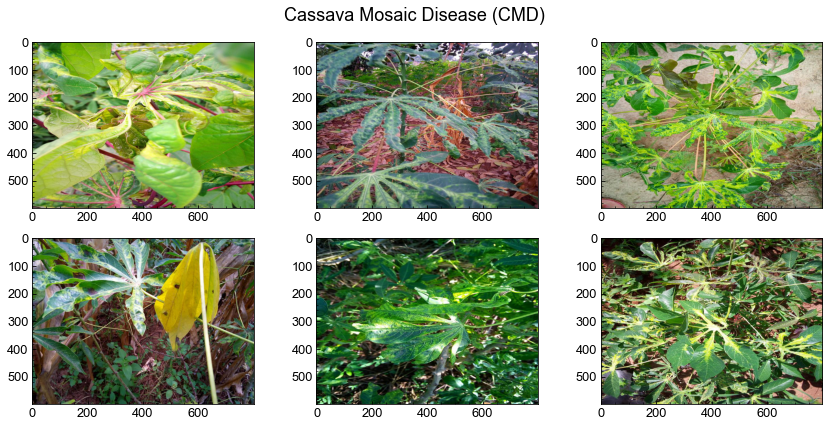

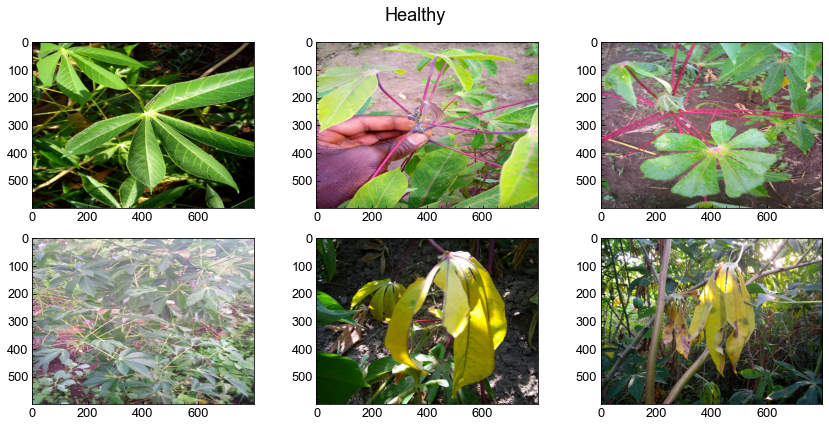

In [15]:
for i in range(5):
    plot_six_by_class(i)

In [16]:
#this doesn't work apparently still in beta, not part of this tf version

#train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir.glob('train_images'), labels=train_df.itertuples(), 
#                                                    label_mode='int', image_size=(600,800), batch_size=32, 
#                                                    validation_split=0.2, seed=123, subset='training')

## Playing around with image processing

In [17]:
im = PIL.Image.open(train_images[0])

In [18]:
print('format:', im.format)
print('mode:', im.mode)
print('size:', im.size)

format: JPEG
mode: RGB
size: (800, 600)


In [19]:
from matplotlib import image

In [20]:
def load_first_n_images(n, directory_path, verbose=False):
    
    """Loads the first n images in a directory into a list of numpy arrays.
    If you want to load all images set n=-1
    
    Arguments: 
    n - the number of images to load, OR -1 to indicate loading all
    directory_path - the path to the image directory
    
    Returns:
    A list of numpy arrays where each array is the pixel array for each image."""
    
    loaded_images = []
    counter = 0

    for filename in os.listdir(directory_path):
        
        #load and append image data
        impath = directory_path + '/' + filename
        img_data = image.imread(impath)
        loaded_images.append(img_data)
        
        #print message and check counter
        if verbose:
            print(' ** loaded image %s: %s **' % (counter + 1, filename))
            
        counter += 1
        if counter >= n and n != -1:
            break
            
    return loaded_images


In [21]:
train_path = '../data/external/train_images'

In [22]:
batch = load_first_n_images(30, train_path)

In [23]:
reds = np.array([batch[i][:,:,0] for i in range(len(batch))])
greens = np.array([batch[i][:,:,1] for i in range(len(batch))])
blues = np.array([batch[i][:,:,2] for i in range(len(batch))])

In [24]:
reds = reds.reshape(1,-1).flatten()
greens = greens.reshape(1,-1).flatten()
blues = blues.reshape(1,-1).flatten()

In [25]:
reds.shape

(14400000,)

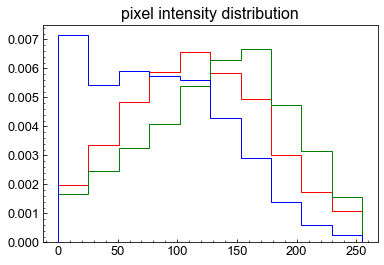

In [26]:
#I don't really expect these to be significantly different, just exploring 
plt.hist(reds, density=True, color='red', histtype='step')
plt.hist(greens, density=True, color='green', histtype='step')
plt.hist(blues, density=True, color='blue', histtype='step')
plt.title("pixel intensity distribution")
plt.show()

In [27]:
def load_images_by_name(list_of_names, directory_path, verbose=False):
    
    """Loads the listed images in a directory into a list of numpy arrays.
    If you want to load all images set n=-1
    
    Arguments: 
    list_of_names - list or iterable with the image names to load
    directory_path - the path to the image directory
    
    Returns:
    A list of numpy arrays where each array is the pixel array for each image."""
    
    loaded_images = []

    for image_name in list_of_names:
        
        #load and append image data
        impath = directory_path + '/' + image_name
        img_data = image.imread(impath)
        loaded_images.append(img_data)
        
        #print message and check counter
        if verbose:
            print(' ** loaded image %s: %s **' % (counter + 1, filename))
            
    return loaded_images

In [28]:
cbb_list = train_df[train_df.label == 0].image_id.values
cbsd_list = train_df[train_df.label == 1].image_id.values
cgm_list = train_df[train_df.label == 2].image_id.values
cmd_list = train_df[train_df.label == 3].image_id.values
healthy_list = train_df[train_df.label == 4].image_id.values

In [29]:
cbb = load_images_by_name(cbb_list[:30], train_path)
cbsd = load_images_by_name(cbsd_list[:30], train_path)
cgm = load_images_by_name(cgm_list[:30], train_path)
cmd = load_images_by_name(cmd_list[:30], train_path)
healthy = load_images_by_name(healthy_list[:30], train_path)

In [30]:
def hist_pixel_intensities(im_data, title_add=None):
    
    """Returns a plot of the pixel intensity distributions by color """
    
    reds = np.array([im_data[i][:,:,0] for i in range(len(im_data))]).reshape(1,-1).flatten()
    greens = np.array([im_data[i][:,:,1] for i in range(len(im_data))]).reshape(1,-1).flatten()
    blues = np.array([im_data[i][:,:,2] for i in range(len(im_data))]).reshape(1,-1).flatten()
    
    plt.hist(reds, density=True, color='red', histtype='step')
    plt.hist(greens, density=True, color='green', histtype='step')
    plt.hist(blues, density=True, color='blue', histtype='step')
    
    if title_add:
        plt.title("pixel intensity distribution: "+ title_add)
    else:
        plt.title("pixel intensity distribution")
        
    plt.show()

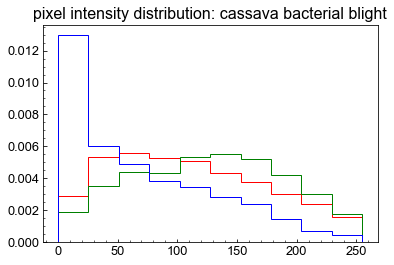

In [31]:
hist_pixel_intensities(cbb, title_add='cassava bacterial blight')

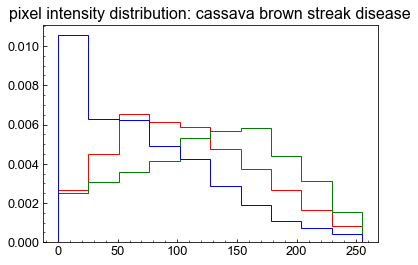

In [32]:
hist_pixel_intensities(cbsd, title_add='cassava brown streak disease')

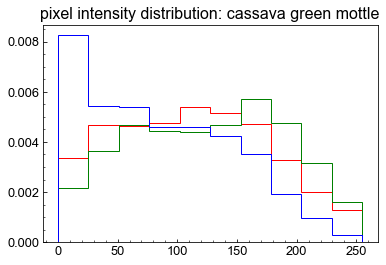

In [33]:
hist_pixel_intensities(cgm, title_add='cassava green mottle')

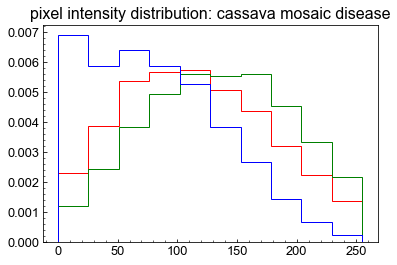

In [34]:
hist_pixel_intensities(cmd, title_add='cassava mosaic disease')

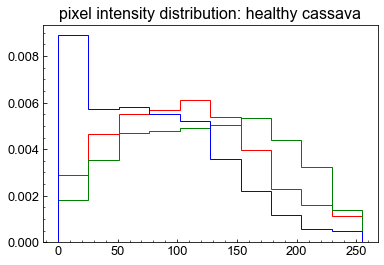

In [35]:
hist_pixel_intensities(healthy, title_add='healthy cassava')

## tfrecords

I don't really know what these are at all yet, but I will figure it out!

In [36]:
train_record_files = list(data_dir.glob('train_tfrecords/*.tfrec'))

In [37]:
raw_dataset = tf.data.TFRecordDataset(str(train_record_files[0]))

In [38]:
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>